In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from natsort import natsorted #숫자 순으로 정렬할 때 1, 10, 11.. 이런 식으로 정렬되는 것을 막기 위해 사용

In [3]:
# 직접 짠 코드
directory = 'TextureSurvey_csv'

dataframes = []
for filename in natsorted(os.listdir(directory)):  
    if filename.endswith('.csv'):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path)
        df.drop(df.columns[0], axis=1, inplace=True)
        dataframes.append(df)

result = dataframes[0].iloc[1]
for i in np.arange(len(dataframes)-1) :
    result = pd.concat([result,dataframes[i+1].iloc[1]],axis=1)
result.columns=np.arange(len(dataframes))+1

data_AllFabrics = []

FiberData=pd.read_csv('FiberData.csv',index_col=0)
FiberNumber=FiberData.index
FiberNumber_NaNDeleted=[x for x in FiberData.index if not np.isnan(x)]

for j in np.arange(len(FiberNumber)):
    data_Fabric = dataframes[0].iloc[j]
    for i in np.arange(len(dataframes)-1) :
        data_Fabric = pd.concat([data_Fabric,dataframes[i+1].iloc[j]],axis=1)
    data_AllFabrics.append(data_Fabric)

In [5]:
fuzzy_variables=['softness', 'smoothness', 'thickness', 'flexibility']

def half_cauchy_distribution_membership(x,a,b):
    if a < x < b:
        return 0.5 -0.5*np.sin((np.pi/(b-a))*(x-(a+b)/2))
    elif b <= x:
        return 1
    else:
        return 0

#원 데이터를 normalize: Min-max feature scaling
def normalized_matrix(i): #i : fabric no index
    dat=data_AllFabrics[i].apply(pd.to_numeric)
    for j in range(dat.shape[0]): #row: 촉감 요소, column: 표본 수
        a=dat.iloc[j].min()
        b=dat.iloc[j].max()
        dat.iloc[j] = (dat.iloc[j] - a)/(b - a)
    return dat

data_AllFabrics_normalized=[]
for i in range(len((data_AllFabrics))):
    data_AllFabrics_normalized.append(normalized_matrix(i))

# 엔트로피 가중치 계산
def weight_of_entropy(i):
    m=len(fuzzy_variables)
    k = 1.0 / np.log(m)

    a=normalized_matrix(i) 
    for j in range(a.shape[0]): #row: 촉감요소 column: 표본
        b=a.iloc[j] #j번째 촉감요소에 대해, 표본 개수 차원을 가진 백터
        c=b.sum()
        a.iloc[j] = a.iloc[j]/c
    entropy = -k * ((a) * np.log(a)).sum(axis=0)
    
    diversity = 1 - entropy
    return diversity / diversity.sum()


weight_vector_AllFabrics=[]
for i in range(len(data_AllFabrics)):
    weight_vector_AllFabrics.append(weight_of_entropy(i))


weight_max=[]
for i in range(len(weight_vector_AllFabrics)):
    weight_max.append(max(weight_vector_AllFabrics[i]))



#membership 함수와 설문 데이터를 이용해 evaluation matrix(fuzzy transformation matrix) 구축

def apply_membership_functions(data):
    data=data.apply(pd.to_numeric)

    membership_values = np.zeros((len(fuzzy_variables), data.shape[1]))

    for i in range(len(fuzzy_variables)):
        for j in range(data.shape[1]):
            membership_values[i, j] = half_cauchy_distribution_membership((data.iloc[i,j]), 1, 5) 
    return pd.DataFrame(membership_values).T #추후 행렬곱 시키기 위해 Transpose



evaluation_matrix_AllFabrics=[]
for i in range(len(data_AllFabrics)):
    evaluation_matrix_AllFabrics.append(apply_membership_functions(data_AllFabrics[i]))

#가중치 행렬과 퍼지 컨버전 행렬과 퍼지 오퍼레이터 연산하여 fuzzy grade matrix 구하기 (각 원단 샘플마다 적용해서 합침)

def fuzzy_operator(data,weight_matrix,evaluation_matrix):
    product= np.dot((weight_matrix.to_numpy()),(evaluation_matrix.fillna(0).to_numpy()))
    
    def rescale(data,lis): 
        data.apply(pd.to_numeric)
        res=[]
        for j in range(data.shape[0]):
            a=data.iloc[j].min()
            b=data.iloc[j].max()
            res_temp = (b-a)*lis[j]+a
            res.append(res_temp)
        return res
    A=pd.Series(rescale(data,product)).fillna(0)
    B=[]
    for i in A:
        asdf=round(i)
        B.append(asdf)
    return B

result=[]
for i in range(len(data_AllFabrics)):
    result.append(fuzzy_operator(data_AllFabrics[i], weight_vector_AllFabrics[i], evaluation_matrix_AllFabrics[i]))
res=pd.DataFrame(result, index=np.arange(1,len(data_AllFabrics)+1,1),columns=fuzzy_variables)
res.to_csv('result_FCE.csv')

/Users/user1/miniforge3/envs/TextureServey/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


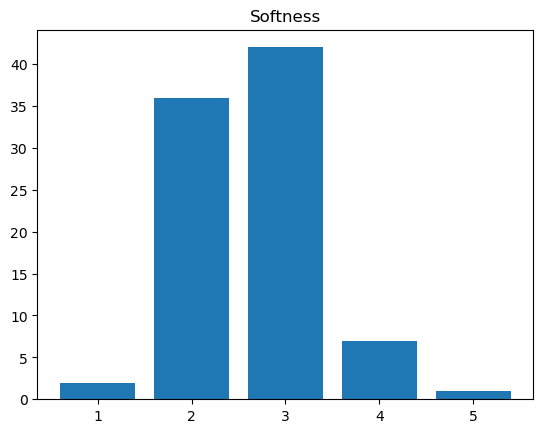

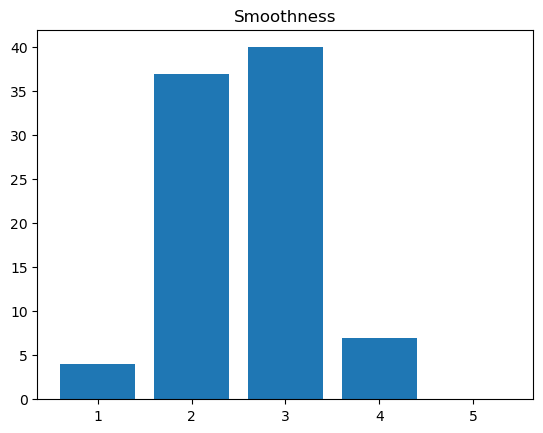

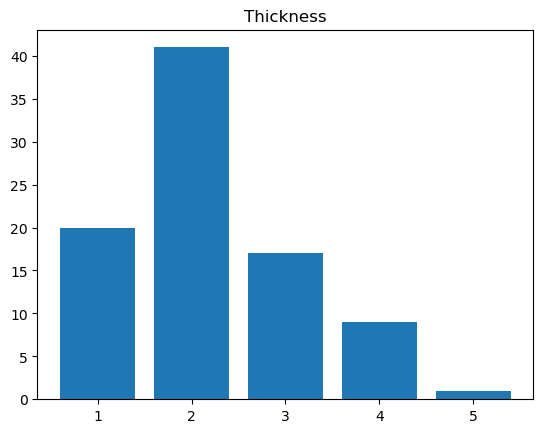

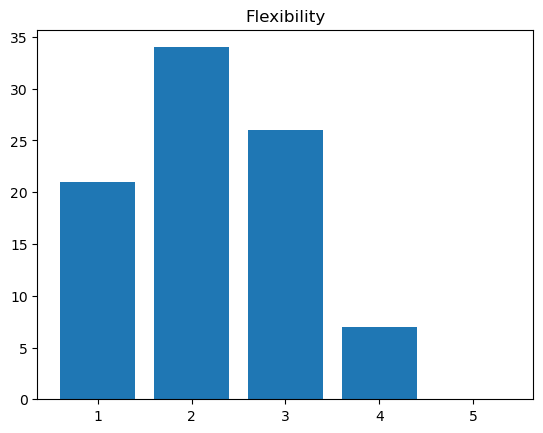

In [6]:
#결과값 분포 확인
label_data = pd.read_csv('res_test.csv')

x = [1, 2, 3, 4, 5]
y1 = []
y2 = []
y3 = []
y4 = []

for i in x:
    res1 = label_data[label_data["softness"]==i].count()
    y1.append(res1[0])
    
    res2 = label_data[label_data["smoothness"]==i].count()
    y2.append(res2[0])

    res3 = label_data[label_data["thickness"]==i].count()
    y3.append(res3[0])

    res4 = label_data[label_data["flexibility"]==i].count()
    y4.append(res4[0])

plt.bar(x,y1)
plt.title('Softness')
plt.show()

plt.bar(x,y2)
plt.title('Smoothness')
plt.show()

plt.bar(x,y3)
plt.title('Thickness')
plt.show()

plt.bar(x,y4)
plt.title('Flexibility')
plt.show()